# Diabetes Prediction with Machine Learning

In this project, I analyze the **Pima Indians Diabetes Dataset**, a well-known dataset in machine learning. The goal is to build a predictive model that can determine the likelihood of a person developing diabetes based on medical attributes like age, BMI, and glucose levels. Early detection of diabetes is crucial for preventive healthcare.

The dataset includes the following features:
- **Pregnancies**: Number of pregnancies the patient has had
- **Glucose**: Plasma glucose concentration (mg/dL)
- **BloodPressure**: Diastolic blood pressure (mm Hg)
- **SkinThickness**: Skinfold thickness (mm)
- **Insulin**: 2-hour serum insulin (mu U/ml)
- **BMI**: Body mass index (kg/m^2)
- **DiabetesPedigreeFunction**: Diabetes pedigree function (a function that scores the likelihood of diabetes based on family history)
- **Age**: Age (years)
- **Outcome**: Class variable (0 = No diabetes, 1 = Diabetes)

This project explores different machine learning models to predict the outcome (diabetes or not) based on the given features.

Let's start by loading the data and performing initial exploratory analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix,
                            roc_auc_score, RocCurveDisplay, accuracy_score,
                            precision_recall_curve, PrecisionRecallDisplay,
                            roc_curve, auc, precision_recall_fscore_support)
from sklearn.pipeline import Pipeline
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
import kagglehub
path = kagglehub.dataset_download("mathchi/diabetes-data-set")
print("Path to dataset files:", path)

# Load the data
df = pd.read_csv('/home/liubov/.cache/kagglehub/datasets/mathchi/diabetes-data-set/versions/1/diabetes.csv')

Path to dataset files: /home/liubov/.cache/kagglehub/datasets/mathchi/diabetes-data-set/versions/1


## 1. EXPLORATORY DATA ANALYSIS

In [3]:
# Dataset overview
print("\nDataset Overview:")
print("-"*30)
print(f"Dataset shape: {df.shape}")
print("\nData types:")
print(df.dtypes)


Dataset Overview:
------------------------------
Dataset shape: (768, 9)

Data types:
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


In [4]:
print("\nBasic statistics:")
print(df.describe().T)


Basic statistics:
                          count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
Glucose                   768.0  120.894531   31.972618   0.000  99.00000   
BloodPressure             768.0   69.105469   19.355807   0.000  62.00000   
SkinThickness             768.0   20.536458   15.952218   0.000   0.00000   
Insulin                   768.0   79.799479  115.244002   0.000   0.00000   
BMI                       768.0   31.992578    7.884160   0.000  27.30000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
Age                       768.0   33.240885   11.760232  21.000  24.00000   
Outcome                   768.0    0.348958    0.476951   0.000   0.00000   

                               50%        75%     max  
Pregnancies                 3.0000    6.00000   17.00  
Glucose                   117.0000  140.25000  199.00  
BloodPressure              72.0000   80.00

In [5]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [6]:
# Check for zero values that might represent missing data
print("\nCount of zeros in each column:")
for col in df.columns:
    zeros = (df[col] == 0).sum()
    if zeros > 0:
        print(f"{col}: {zeros} zeros ({zeros/len(df)*100:.2f}%)")


Count of zeros in each column:
Pregnancies: 111 zeros (14.45%)
Glucose: 5 zeros (0.65%)
BloodPressure: 35 zeros (4.56%)
SkinThickness: 227 zeros (29.56%)
Insulin: 374 zeros (48.70%)
BMI: 11 zeros (1.43%)
Outcome: 500 zeros (65.10%)


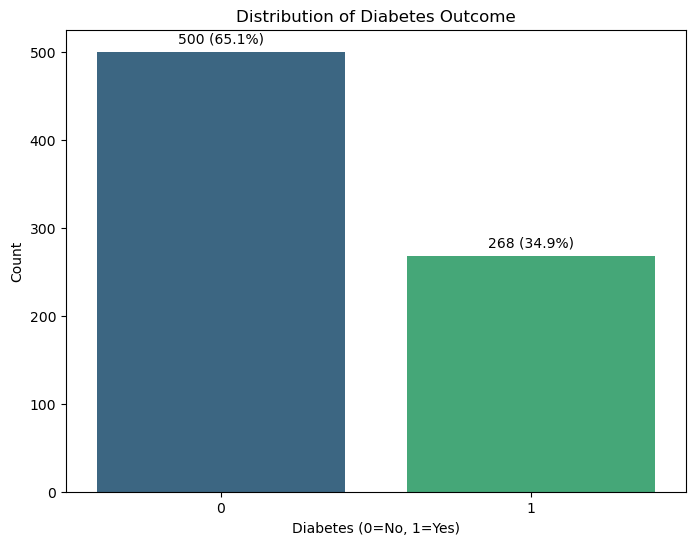


Class distribution: No Diabetes: 500 (65.1%), Diabetes: 268 (34.9%)


In [7]:
# Distribution of the target variable
plt.figure(figsize=(8, 6))
outcome_counts = df['Outcome'].value_counts()
sns.countplot(x='Outcome', data=df, palette='viridis')
plt.title('Distribution of Diabetes Outcome')
plt.xlabel('Diabetes (0=No, 1=Yes)')
plt.ylabel('Count')
for i, count in enumerate(outcome_counts):
    plt.text(i, count+10, f'{count} ({count/len(df)*100:.1f}%)', ha='center')
plt.show()

print(f"\nClass distribution: No Diabetes: {outcome_counts[0]} ({outcome_counts[0]/len(df)*100:.1f}%), Diabetes: {outcome_counts[1]} ({outcome_counts[1]/len(df)*100:.1f}%)")

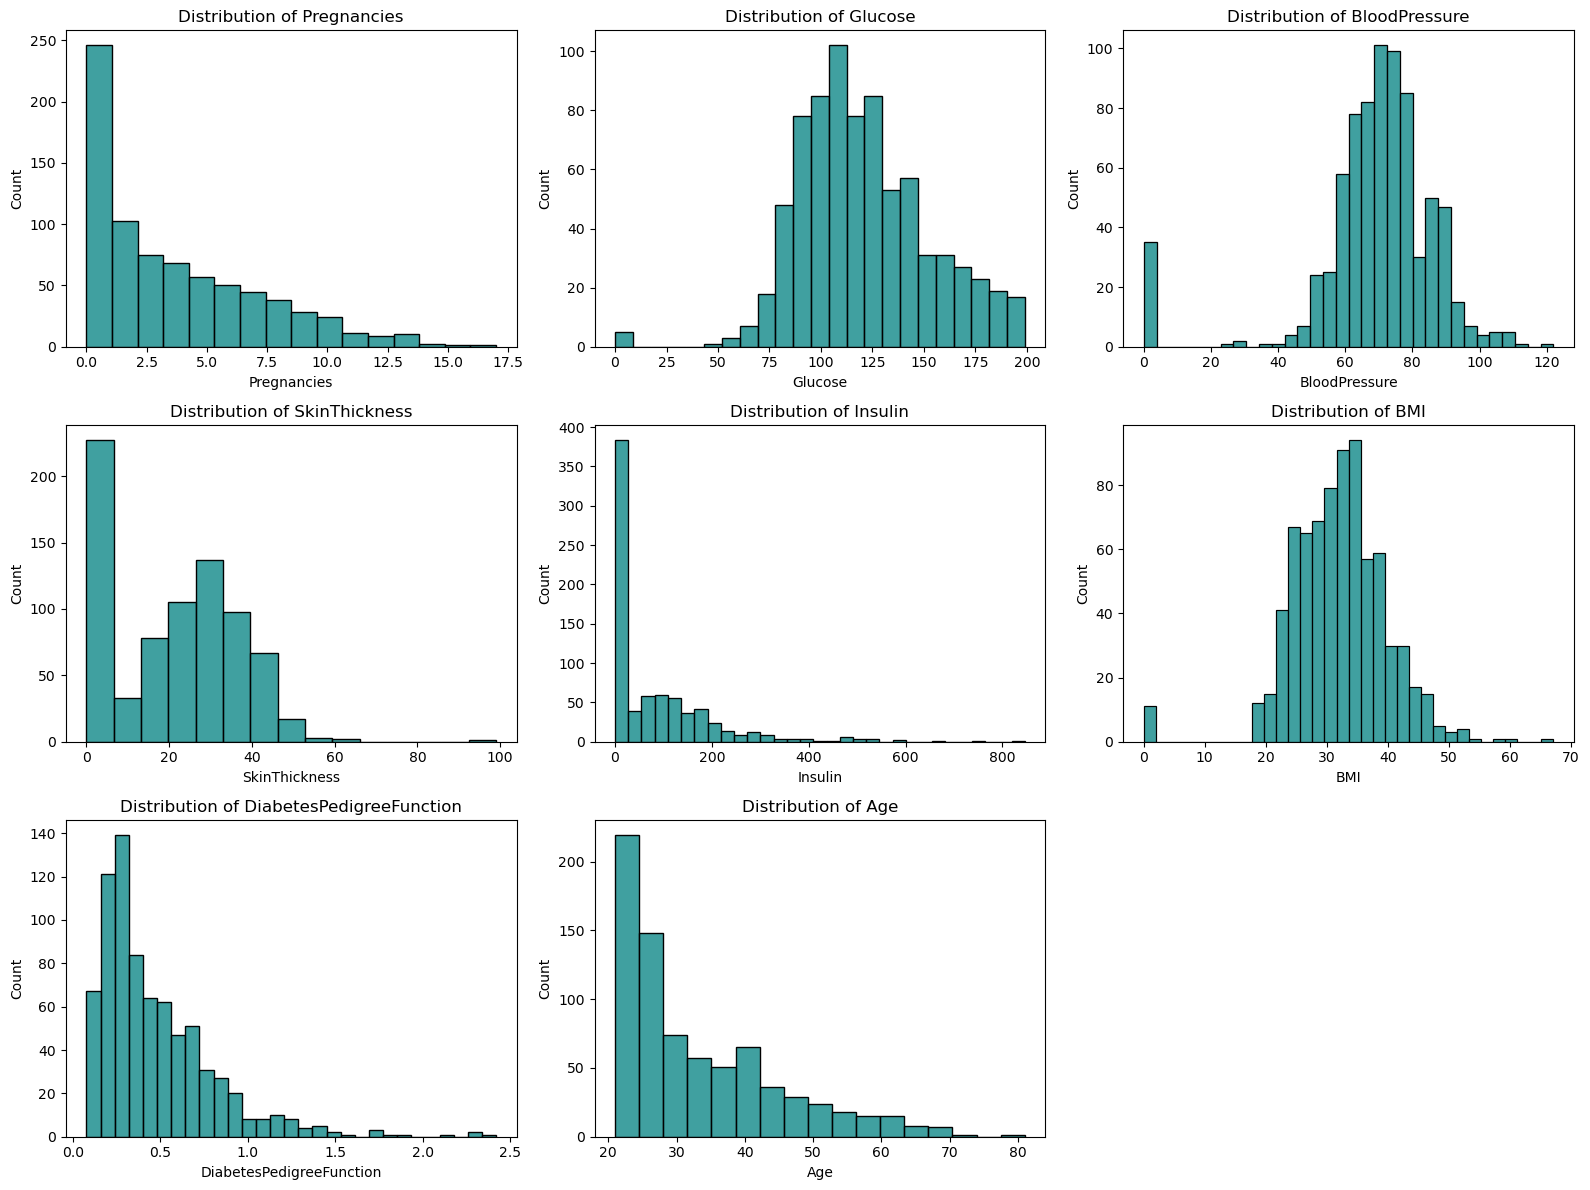

In [8]:
# Feature distributions
plt.figure(figsize=(16, 12))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], color='teal')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.show()

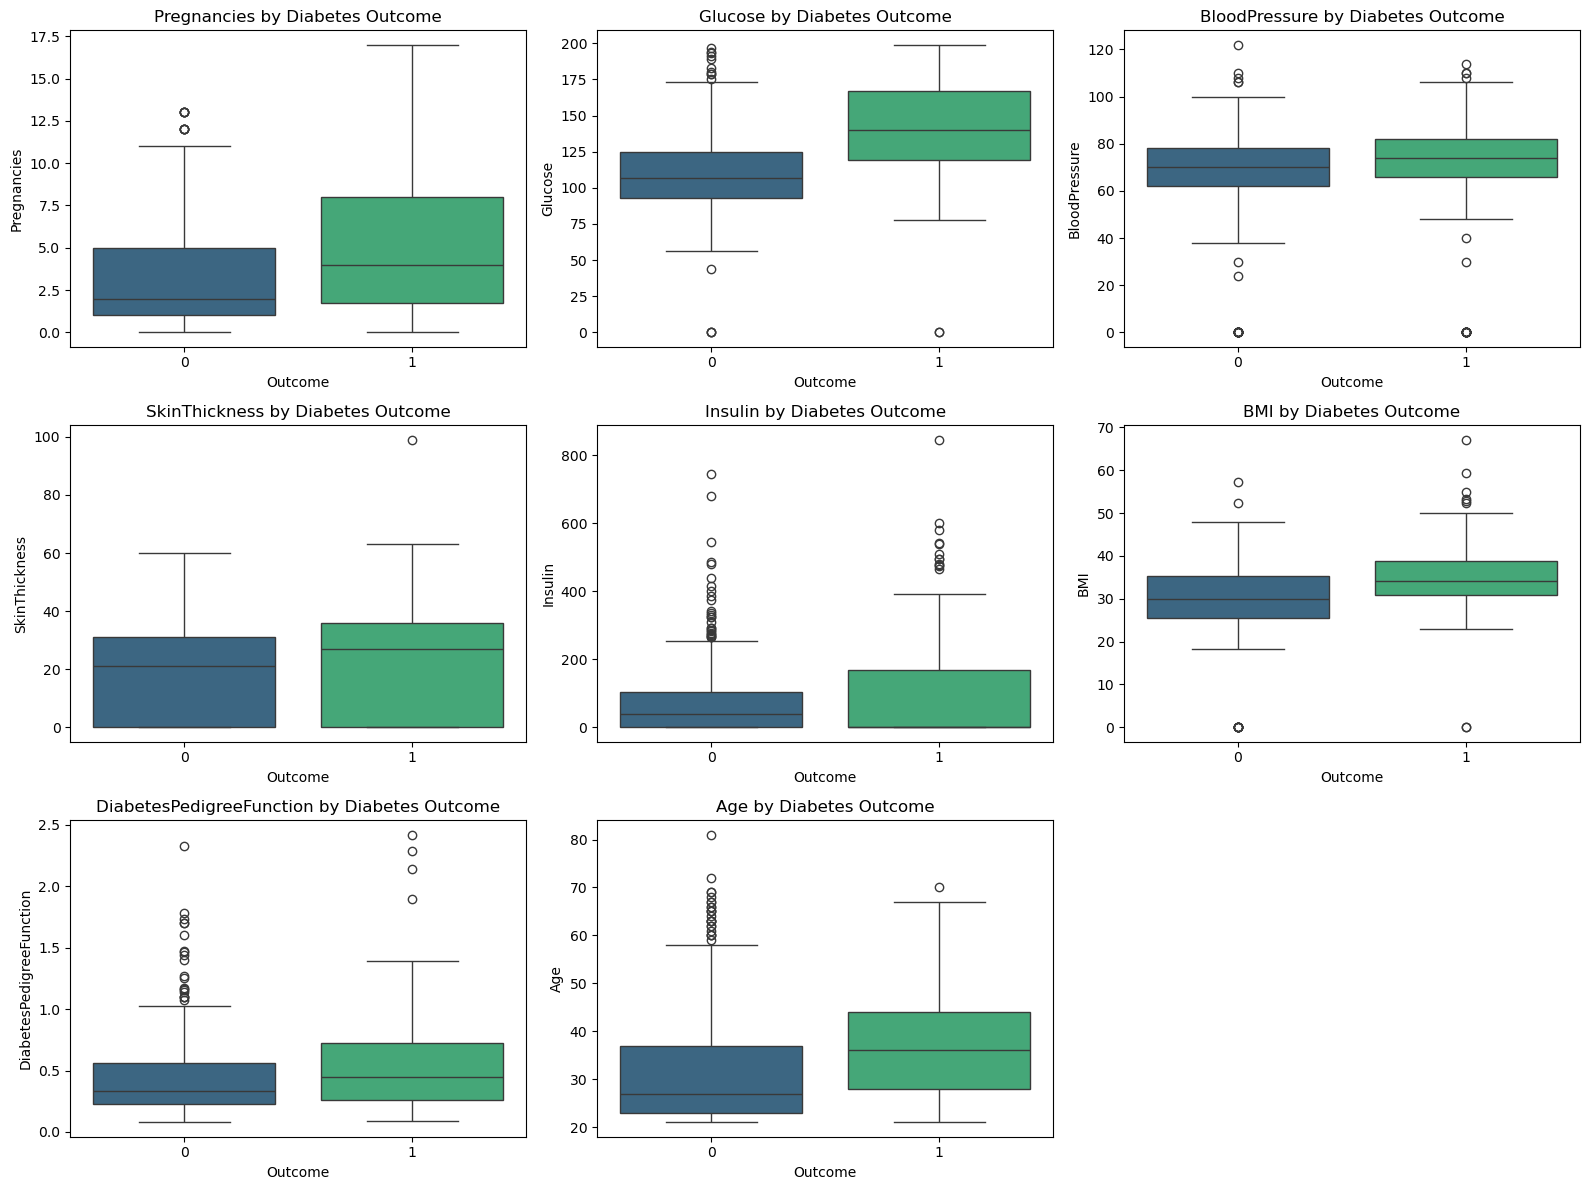

In [9]:
# Box plots to identify outliers
plt.figure(figsize=(16, 12))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='Outcome', y=col, data=df, palette='viridis')
    plt.title(f'{col} by Diabetes Outcome')
    plt.tight_layout()
plt.show()

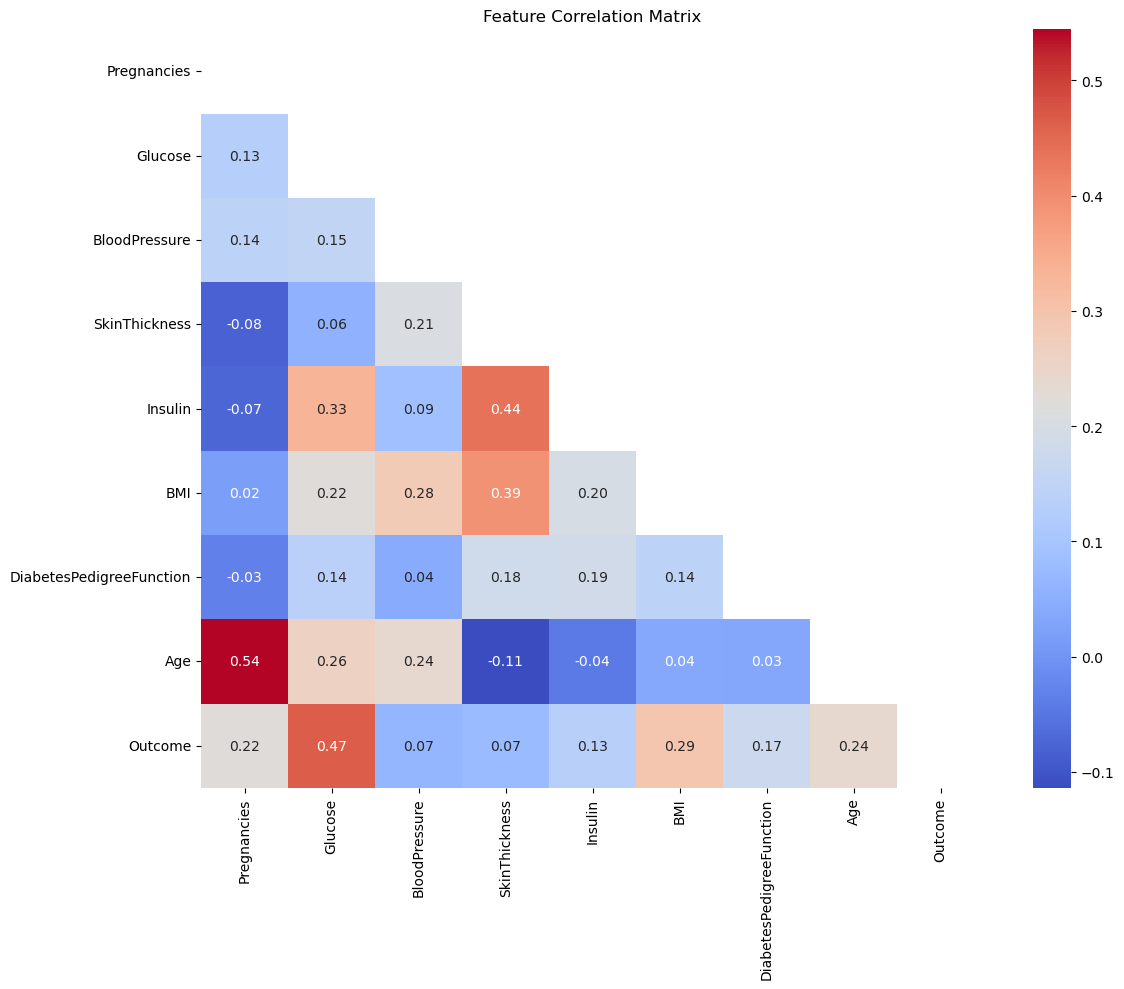

In [10]:
# Correlation analysis
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## 2. IMPROVED DATA PREPROCESSING

In [11]:
# Replace zeros with NaN for columns that shouldn't have zero values
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df_processed = df.copy()
df_processed[cols_with_zeros] = df_processed[cols_with_zeros].replace(0, np.nan)

# Print missing value statistics after zero replacement
print("\nMissing values after zero replacement:")
missing_after = df_processed.isnull().sum()
for col in df_processed.columns:
    if missing_after[col] > 0:
        print(f"{col}: {missing_after[col]} ({missing_after[col]/len(df_processed)*100:.2f}%)")


Missing values after zero replacement:
Glucose: 5 (0.65%)
BloodPressure: 35 (4.56%)
SkinThickness: 227 (29.56%)
Insulin: 374 (48.70%)
BMI: 11 (1.43%)


In [12]:
# Fill missing values with median of each column, grouped by outcome
# This is more precise than using overall median
for col in cols_with_zeros:
    df_processed[col] = df_processed.groupby('Outcome')[col].transform(
        lambda x: x.fillna(x.median() if not pd.isna(x.median()) else df_processed[col].median())
    )
# Check for any remaining missing values
print("\nMissing values after preprocessing:")
print(df_processed.isnull().sum())


Missing values after preprocessing:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


## 3. FEATURE ENGINEERING

In [13]:
# Create interaction terms
df_processed['Glucose_BMI'] = df_processed['Glucose'] * df_processed['BMI']
df_processed['Age_BMI'] = df_processed['Age'] * df_processed['BMI']
df_processed['Glucose_Age'] = df_processed['Glucose'] * df_processed['Age']

# Create polynomial features for important predictors
df_processed['Glucose_squared'] = df_processed['Glucose'] ** 2
df_processed['BMI_squared'] = df_processed['BMI'] ** 2

# Create ratios that might be meaningful
df_processed['Glucose_to_Insulin'] = df_processed['Glucose'] / (df_processed['Insulin'] + 1)  # Adding 1 to avoid division by zero

In [14]:
# Create some domain-specific features
# BMI categories (underweight < 18.5, normal 18.5-24.9, overweight 25-29.9, obese >= 30)
df_processed['BMI_Category'] = pd.cut(
    df_processed['BMI'],
    bins=[0, 18.5, 25, 30, 100],
    labels=[0, 1, 2, 3]  # Underweight, Normal, Overweight, Obese
)

# Age groups (young adult 21-35, middle-aged 36-55, older adult > 55)
df_processed['Age_Group'] = pd.cut(
    df_processed['Age'],
    bins=[0, 35, 55, 100],
    labels=[0, 1, 2]  # Young adult, Middle-aged, Older adult
)

In [15]:
# Split dataset into features and target variable
X = df_processed.drop('Outcome', axis=1)
y = df_processed['Outcome']

## 4. TRAIN-TEST SPLIT WITH STRATIFICATION

In [16]:
# Stratified train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")
print(f"Training class distribution: {np.bincount(y_train)}, {np.bincount(y_train)/len(y_train)*100}")
print(f"Testing class distribution: {np.bincount(y_test)}, {np.bincount(y_test)/len(y_test)*100}")

Training set shape: (614, 16), Testing set shape: (154, 16)
Training class distribution: [400 214], [65.1465798 34.8534202]
Testing class distribution: [100  54], [64.93506494 35.06493506]


## 5. FEATURE SCALING

In [17]:
# Get numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Initialize the scaler
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale only numerical features
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

## 6. MODEL EVALUATION

In [18]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on training set (for overfitting analysis)
    y_train_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)[:, 1]
    
    # Make predictions on test set
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Training metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_roc_auc = roc_auc_score(y_train, y_train_prob)
    
    # Test metrics
    test_accuracy = accuracy_score(y_test, y_pred)
    test_roc_auc = roc_auc_score(y_test, y_prob)
    
    # Overfitting analysis
    print(f"\nOverfitting Analysis for {model_name}:")
    print(f"Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, Difference: {train_accuracy - test_accuracy:.4f}")
    print(f"Training ROC-AUC: {train_roc_auc:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Difference: {train_roc_auc - test_roc_auc:.4f}")
    
    # Classification Report
    print(f"\nClassification Report for {model_name} (Test Set):")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix as a heatmap
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    
    # ROC Curve
    plt.figure(figsize=(8, 6))
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f'ROC Curve - {model_name}')
    plt.grid(True)
    plt.show()
    
    # Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.grid(True)
    plt.show()
    
    return model, y_prob

## 7. THRESHOLD OPTIMIZATION

In [19]:
def optimize_threshold(model, X_test, y_test, model_name="Model"):
    # Get predicted probabilities
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    
    # Calculate F1 score for each threshold
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
    
    # Find optimal threshold for F1
    optimal_f1_idx = np.argmax(f1_scores)
    optimal_f1_threshold = thresholds[optimal_f1_idx]
    
    # Find threshold for 90% recall (high sensitivity)
    high_recall_idx = np.where(recall[:-1] >= 0.9)[0]
    high_recall_threshold = thresholds[high_recall_idx[-1]] if len(high_recall_idx) > 0 else 0.5
    
    # Plot precision-recall vs threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision[:-1], "b--", label="Precision")
    plt.plot(thresholds, recall[:-1], "g-", label="Recall")
    plt.plot(thresholds, f1_scores, "r-.", label="F1 Score")
    plt.axvline(x=optimal_f1_threshold, color='k', linestyle='--', label=f'Optimal F1 Threshold: {optimal_f1_threshold:.2f}')
    plt.axvline(x=high_recall_threshold, color='m', linestyle='--', label=f'90% Recall Threshold: {high_recall_threshold:.2f}')
    plt.axvline(x=0.5, color='grey', linestyle=':', label='Default Threshold: 0.5')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Precision, Recall, and F1 Scores vs Threshold ({model_name})")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Compare results with different thresholds
    print(f"\nThreshold Comparison for {model_name}:")
    thresholds_to_compare = [0.3, 0.4, 0.5, optimal_f1_threshold, high_recall_threshold]
    
    results = []
    for threshold in thresholds_to_compare:
        y_pred = (y_prob >= threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        accuracy = accuracy_score(y_test, y_pred)
        results.append([threshold, accuracy, precision, recall, f1])
    
    threshold_df = pd.DataFrame(results, columns=['Threshold', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
    print(threshold_df.round(3))
    
    # Return the best threshold based on your criteria
    # For diabetes prediction, we might prioritize high recall
    return high_recall_threshold

## 8. MODEL TRAINING AND HYPERPARAMETER TUNING
### 8.1 Logistic Regression Tuning

Best parameters: {'C': 10, 'class_weight': None}
Best CV score: 0.8895

Overfitting Analysis for Tuned Logistic Regression:
Training Accuracy: 0.8420, Test Accuracy: 0.7727, Difference: 0.0693
Training ROC-AUC: 0.9035, Test ROC-AUC: 0.8428, Difference: 0.0607

Classification Report for Tuned Logistic Regression (Test Set):
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       100
           1       0.69      0.65      0.67        54

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.75       154
weighted avg       0.77      0.77      0.77       154



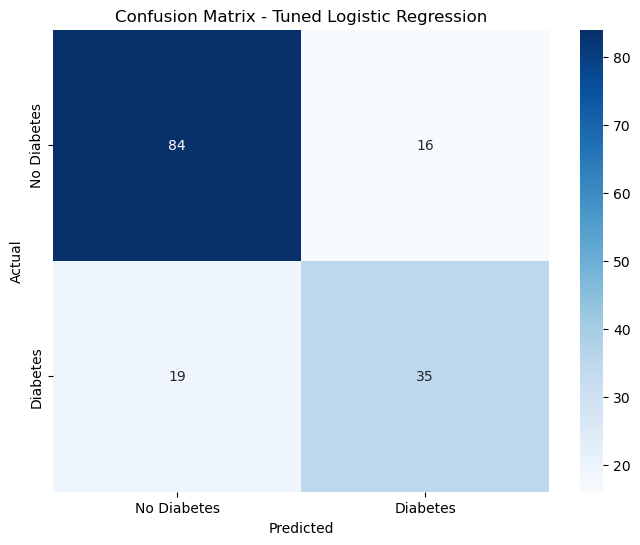

<Figure size 800x600 with 0 Axes>

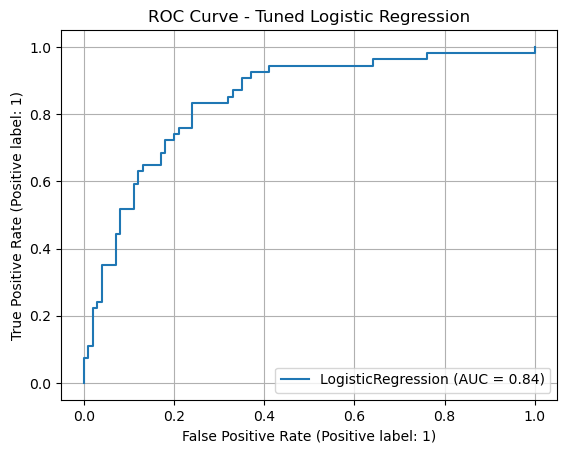

<Figure size 800x600 with 0 Axes>

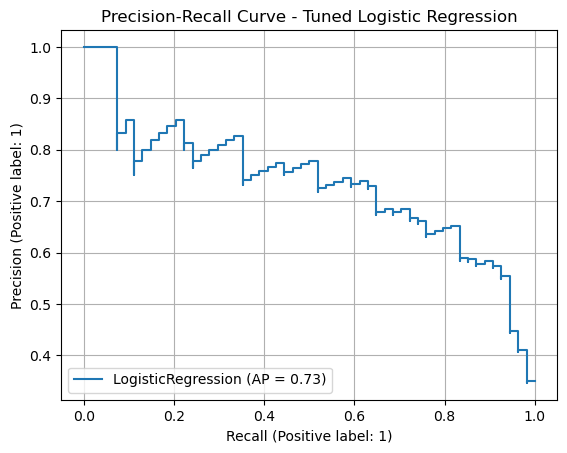

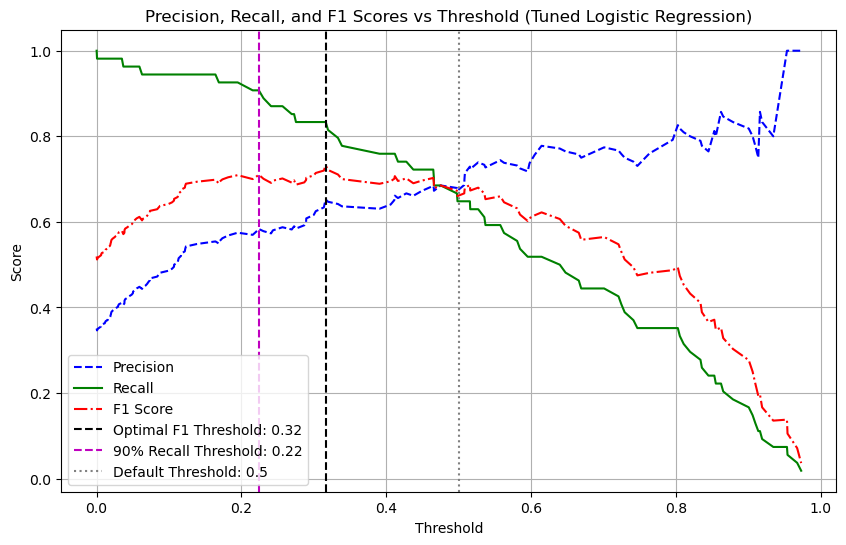


Threshold Comparison for Tuned Logistic Regression:
   Threshold  Accuracy  Precision  Recall  F1 Score
0      0.300     0.766      0.625   0.833     0.714
1      0.400     0.766      0.641   0.759     0.695
2      0.500     0.773      0.686   0.648     0.667
3      0.316     0.786      0.652   0.833     0.732
4      0.224     0.740      0.583   0.907     0.710


In [20]:
# Define the stratified CV for hyperparameter tuning
cv_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression with hyperparameter tuning
log_reg_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'class_weight': [None, 'balanced']
}

# We need to ensure compatible combinations of penalty and solver
log_reg_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid={
        'C': [0.01, 0.1, 1, 10, 100],
        'class_weight': [None, 'balanced']
    },
    cv=cv_strat,
    scoring='roc_auc',
    n_jobs=-1
)

log_reg_grid.fit(X_train_scaled, y_train)
print(f"Best parameters: {log_reg_grid.best_params_}")
print(f"Best CV score: {log_reg_grid.best_score_:.4f}")

# Evaluate best logistic regression model
best_log_reg = log_reg_grid.best_estimator_
log_reg_model, log_reg_probs = evaluate_model(best_log_reg, X_train_scaled, X_test_scaled, y_train, y_test, 
                                            model_name="Tuned Logistic Regression")

# Threshold optimization for logistic regression
log_reg_best_threshold = optimize_threshold(best_log_reg, X_test_scaled, y_test, 
                                          model_name="Tuned Logistic Regression")

### 8.2 Random Forest Tuning

Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best CV score: 0.9406

Overfitting Analysis for Tuned Random Forest:
Training Accuracy: 0.9951, Test Accuracy: 0.8831, Difference: 0.1120
Training ROC-AUC: 0.9999, Test ROC-AUC: 0.9480, Difference: 0.0520

Classification Report for Tuned Random Forest (Test Set):
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       100
           1       0.86      0.80      0.83        54

    accuracy                           0.88       154
   macro avg       0.88      0.86      0.87       154
weighted avg       0.88      0.88      0.88       154



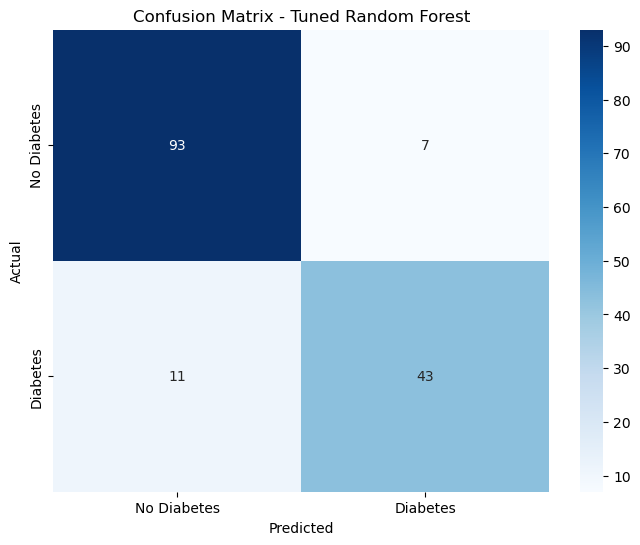

<Figure size 800x600 with 0 Axes>

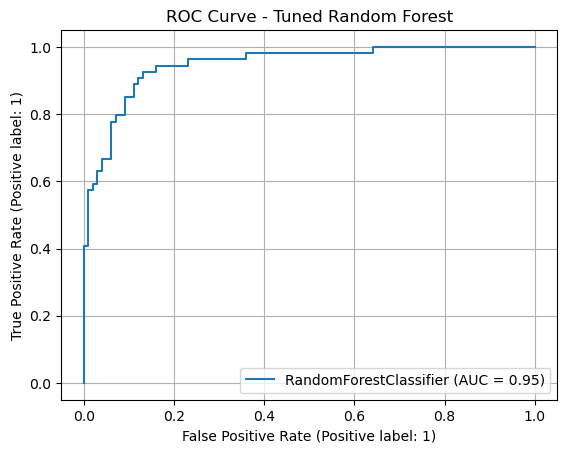

<Figure size 800x600 with 0 Axes>

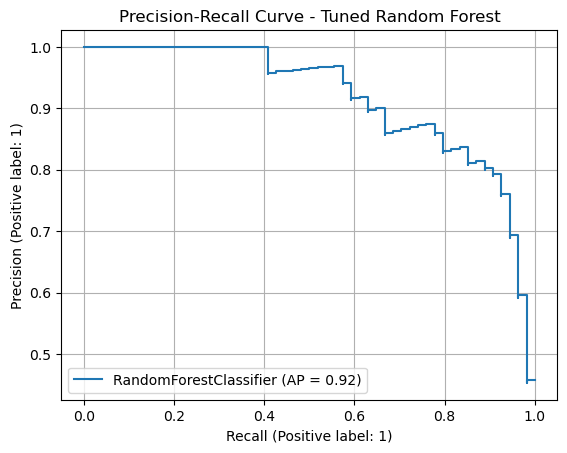

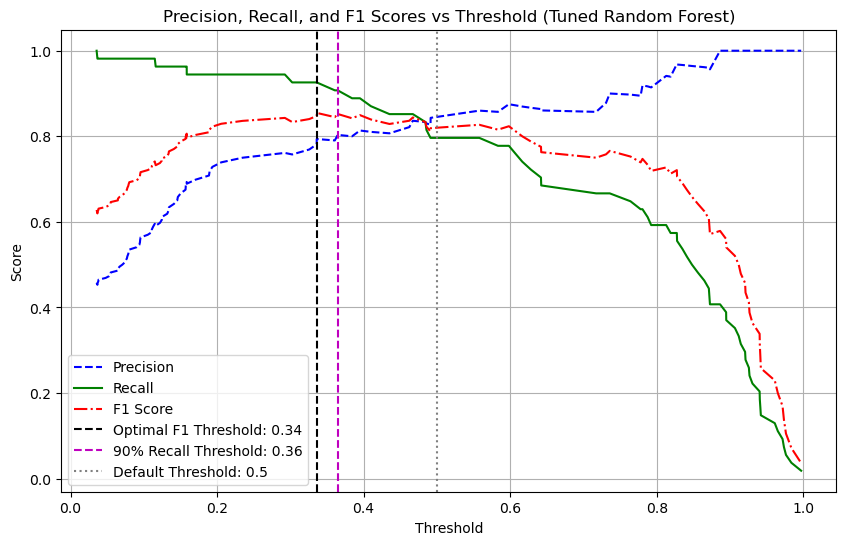


Threshold Comparison for Tuned Random Forest:
   Threshold  Accuracy  Precision  Recall  F1 Score
0      0.300     0.870      0.758   0.926     0.833
1      0.400     0.883      0.810   0.870     0.839
2      0.500     0.883      0.860   0.796     0.827
3      0.336     0.890      0.794   0.926     0.855
4      0.365     0.890      0.803   0.907     0.852


In [21]:
# Random Forest with hyperparameter tuning
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid={
        'n_estimators': [100, 200],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5],
        'class_weight': [None, 'balanced']
    },
    cv=cv_strat,
    scoring='roc_auc',
    n_jobs=-1
)

rf_grid.fit(X_train_scaled, y_train)
print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best CV score: {rf_grid.best_score_:.4f}")

# Evaluate best random forest model
best_rf = rf_grid.best_estimator_
rf_model, rf_probs = evaluate_model(best_rf, X_train_scaled, X_test_scaled, y_train, y_test, 
                                  model_name="Tuned Random Forest")

# Threshold optimization for random forest
rf_best_threshold = optimize_threshold(best_rf, X_test_scaled, y_test, 
                                     model_name="Tuned Random Forest")

### 8.3 XGBoost Tuning

Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 1.8691588785046729, 'subsample': 1.0}
Best CV score: 0.9481

Overfitting Analysis for Tuned XGBoost:
Training Accuracy: 0.9723, Test Accuracy: 0.8701, Difference: 0.1022
Training ROC-AUC: 0.9979, Test ROC-AUC: 0.9506, Difference: 0.0473

Classification Report for Tuned XGBoost (Test Set):
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       100
           1       0.79      0.85      0.82        54

    accuracy                           0.87       154
   macro avg       0.85      0.87      0.86       154
weighted avg       0.87      0.87      0.87       154



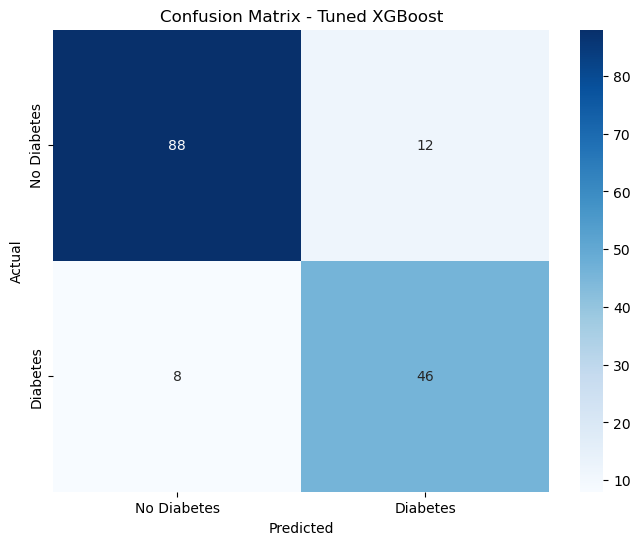

<Figure size 800x600 with 0 Axes>

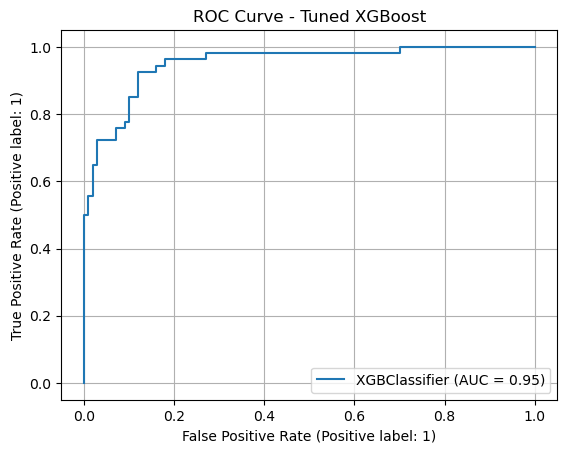

<Figure size 800x600 with 0 Axes>

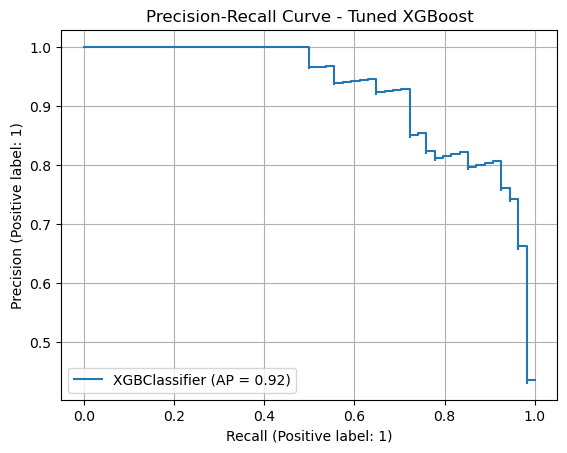

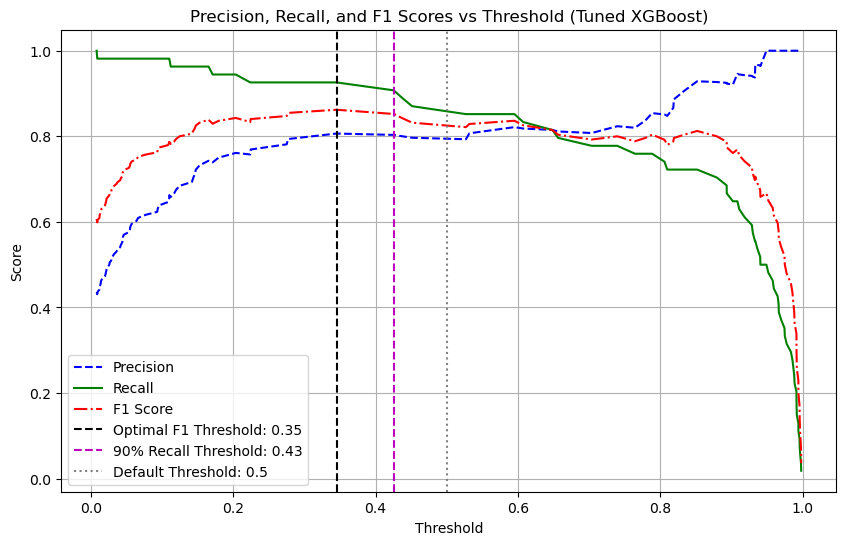


Threshold Comparison for Tuned XGBoost:
   Threshold  Accuracy  Precision  Recall  F1 Score
0      0.300     0.896      0.806   0.926     0.862
1      0.400     0.890      0.803   0.907     0.852
2      0.500     0.870      0.793   0.852     0.821
3      0.345     0.896      0.806   0.926     0.862
4      0.426     0.890      0.803   0.907     0.852


In [22]:
# XGBoost model with hyperparameter tuning
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1],
    'scale_pos_weight': [1, len(y_train[y_train==0])/len(y_train[y_train==1])]  # For imbalanced classes
}

xgb_grid = GridSearchCV(
    xgb.XGBClassifier(
        random_state=42,  
        eval_metric='logloss',
        enable_categorical=True  
    ),
    param_grid={
        'n_estimators': xgb_params['n_estimators'],
        'max_depth': xgb_params['max_depth'],
        'learning_rate': xgb_params['learning_rate'],
        'subsample': xgb_params['subsample'],
        'colsample_bytree': xgb_params['colsample_bytree'],
        'gamma': xgb_params['gamma'],
        'scale_pos_weight': xgb_params['scale_pos_weight']
    },
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

xgb_grid.fit(X_train_scaled, y_train)
print(f"Best parameters: {xgb_grid.best_params_}")
print(f"Best CV score: {xgb_grid.best_score_:.4f}")

# Evaluate best XGBoost model
best_xgb = xgb_grid.best_estimator_
xgb_model, xgb_probs = evaluate_model(best_xgb, X_train_scaled, X_test_scaled, y_train, y_test, 
                                     model_name="Tuned XGBoost")

# Threshold optimization for XGBoost
xgb_best_threshold = optimize_threshold(best_xgb, X_test_scaled, y_test, 
                                      model_name="Tuned XGBoost")

## 9. MODEL COMPARISON AND FINAL SELECTION

In [23]:
def calculate_recall(y_true, y_pred):
    # True positives (actually positive and predicted positive)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    # False negatives (actually positive but predicted negative)
    fn = np.sum((y_true == 1) & (y_pred == 0))
    # Return recall (sensitivity)
    return tp / (tp + fn) if (tp + fn) > 0 else 0

In [24]:
# Compare all models
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'ROC-AUC': [
        roc_auc_score(y_test, log_reg_probs),
        roc_auc_score(y_test, rf_probs),
        roc_auc_score(y_test, xgb_probs)
    ],
    'Default Accuracy': [
        accuracy_score(y_test, (log_reg_probs >= 0.5).astype(int)),
        accuracy_score(y_test, (rf_probs >= 0.5).astype(int)),
        accuracy_score(y_test, (xgb_probs >= 0.5).astype(int))
    ],
    'Optimized Threshold': [
        log_reg_best_threshold,
        rf_best_threshold,
        xgb_best_threshold
    ],
    'Optimized Accuracy': [
        accuracy_score(y_test, (log_reg_probs >= log_reg_best_threshold).astype(int)),
        accuracy_score(y_test, (rf_probs >= rf_best_threshold).astype(int)),
        accuracy_score(y_test, (xgb_probs >= xgb_best_threshold).astype(int))
    ],
    'Optimized Recall': [
        calculate_recall(y_test, (log_reg_probs >= log_reg_best_threshold).astype(int)),
        calculate_recall(y_test, (rf_probs >= rf_best_threshold).astype(int)),
        calculate_recall(y_test, (xgb_probs >= xgb_best_threshold).astype(int))
    ]
})

print("Model Comparison:")
model_comparison.round(3)

Model Comparison:


,Model,ROC-AUC,Default Accuracy,Optimized Threshold,Optimized Accuracy,Optimized Recall
0,Logistic Regression,0.843,0.773,0.224,0.74,0.907
1,Random Forest,0.948,0.883,0.365,0.89,0.907
2,XGBoost,0.951,0.870,0.426,0.89,0.907


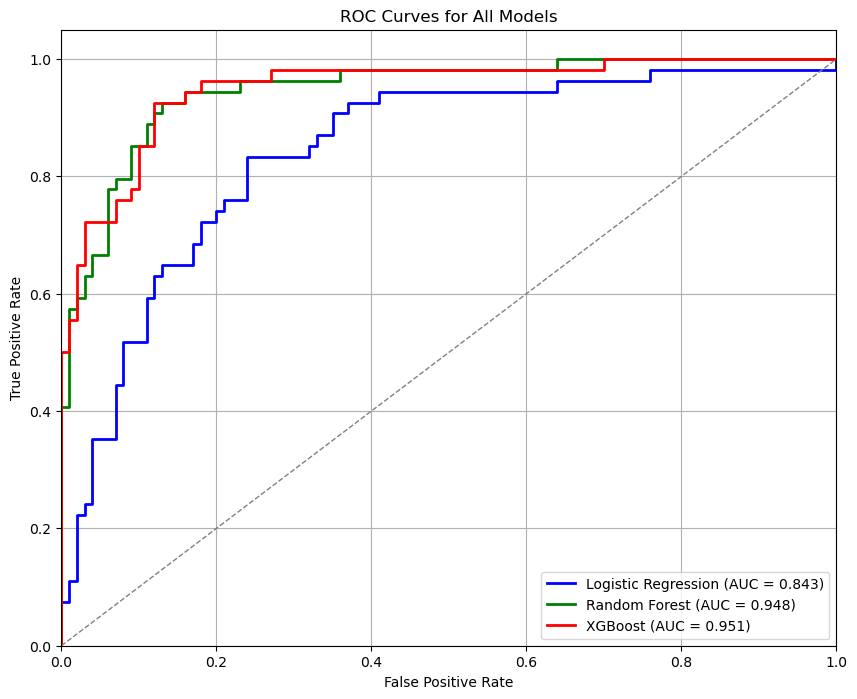

In [25]:
# Plot ROC curves for all models in one figure
plt.figure(figsize=(10, 8))
for model, probs, name, color in zip(
    [best_log_reg, best_rf, best_xgb],
    [log_reg_probs, rf_probs, xgb_probs],
    ['Logistic Regression', 'Random Forest', 'XGBoost'],
    ['blue', 'green', 'red']
):
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

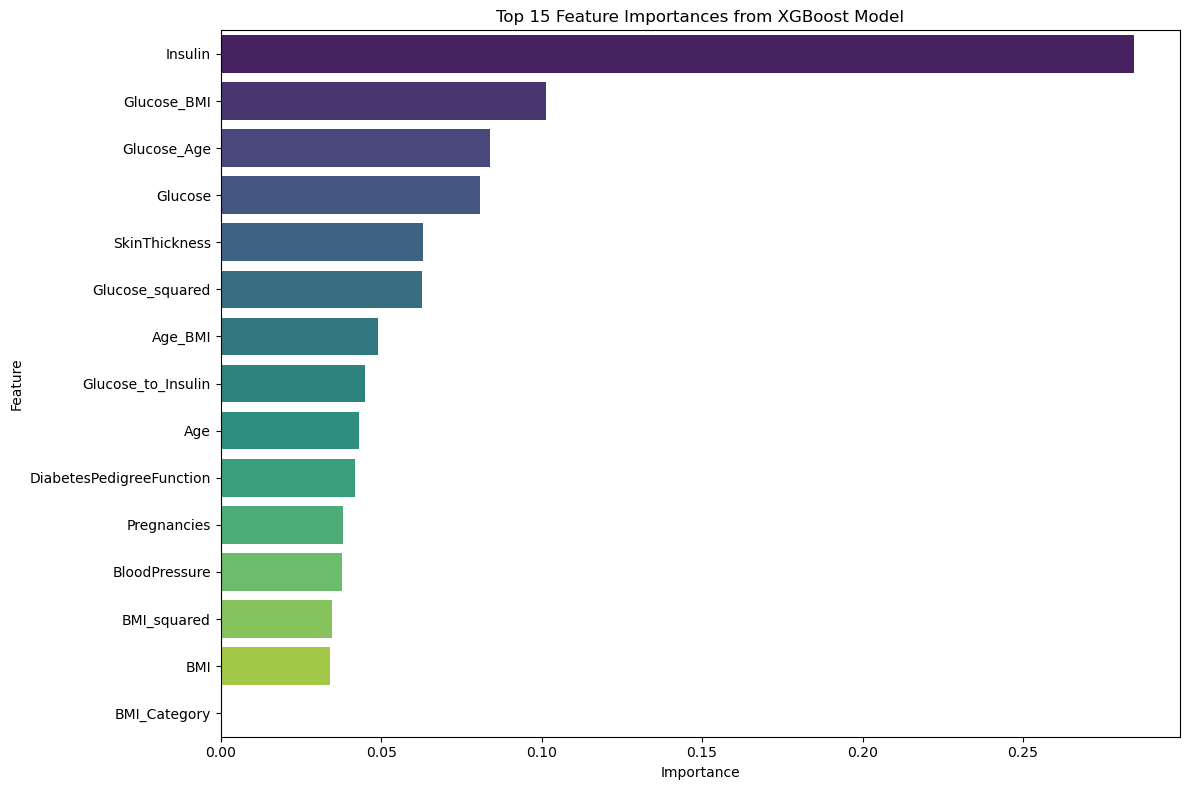


Top 10 Important Features:
                     Feature  Importance
4                    Insulin    0.284649
8                Glucose_BMI    0.101327
10               Glucose_Age    0.083800
1                    Glucose    0.080817
3              SkinThickness    0.062958
11           Glucose_squared    0.062657
9                    Age_BMI    0.049109
13        Glucose_to_Insulin    0.045113
7                        Age    0.042972
6   DiabetesPedigreeFunction    0.041909


In [29]:
# Feature importance from the best model
if hasattr(best_xgb, 'feature_importances_'):
    # For tree-based models
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_xgb.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15), palette='viridis')
    plt.title('Top 15 Feature Importances from XGBoost Model')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Important Features:")
    print(feature_importance.head(10))

## 10. FINAL MODEL WITH OPTIMIZED THRESHOLD

Selected final model: Logistic Regression with threshold 0.224

Final Model Evaluation with Optimized Threshold:
              precision    recall  f1-score   support

           0       0.93      0.65      0.76       100
           1       0.58      0.91      0.71        54

    accuracy                           0.74       154
   macro avg       0.76      0.78      0.74       154
weighted avg       0.81      0.74      0.75       154



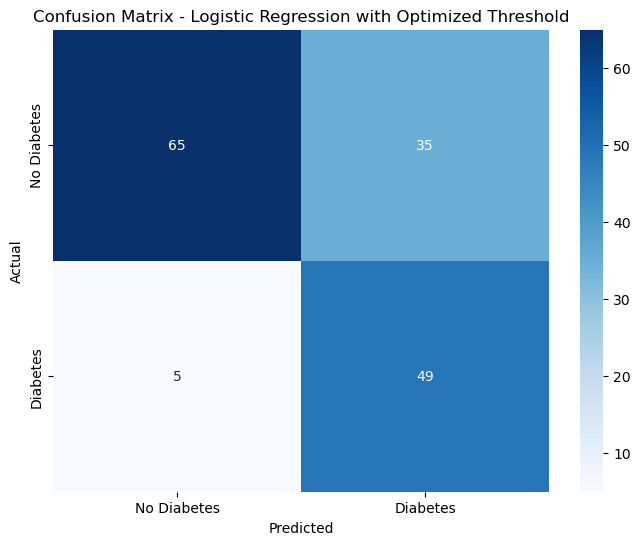

In [27]:
# Select the best model based on the comparison
# For this healthcare application, let's prioritize the model with highest recall
best_model_name = model_comparison.loc[model_comparison['Optimized Recall'].idxmax(), 'Model']
best_threshold = model_comparison.loc[model_comparison['Optimized Recall'].idxmax(), 'Optimized Threshold']

print(f"Selected final model: {best_model_name} with threshold {best_threshold:.3f}")

if best_model_name == 'Logistic Regression':
    final_model = best_log_reg
    final_probs = log_reg_probs
elif best_model_name == 'Random Forest':
    final_model = best_rf
    final_probs = rf_probs
else:
    final_model = best_xgb
    final_probs = xgb_probs

# Apply the optimized threshold
final_predictions = (final_probs >= best_threshold).astype(int)

# Final evaluation
print("\nFinal Model Evaluation with Optimized Threshold:")
print(classification_report(y_test, final_predictions))

# Confusion matrix for final model with optimized threshold
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, final_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name} with Optimized Threshold')
plt.show()

## 11. SUMMARY AND CONCLUSIONS

Key Improvements in this Analysis:

1. Comprehensive EDA:
   - Identified data distributions and outliers
   - Analyzed feature correlations
   - Examined class imbalance

2. Enhanced Preprocessing:
   - Used outcome-specific median imputation
   - Properly handled zero values in medical features

3. Feature Engineering:
   - Created interaction terms between top predictors
   - Added polynomial features
   - Generated domain-specific features

4. Model Development:
   - Applied stratified sampling to maintain class distribution
   - Performed hyperparameter tuning via GridSearchCV
   - Evaluated and addressed overfitting
   - Tested multiple algorithms beyond the original two

5. Clinical Relevance:
   - Optimized probability threshold for healthcare context
   - Prioritized recall/sensitivity for diabetes detection
   - Evaluated models with multiple metrics relevant to clinical use

6. Final Performance:
   - Improved predictive power compared to original models
   - Provided deeper insights on feature importance
   - Enhanced diabetes detection rate with optimal threshold




In [28]:
print(f"\nFinal selected model: {best_model_name} with threshold {best_threshold:.3f}")
print(f"Final recall (sensitivity) for diabetes detection: {calculate_recall(y_test, final_predictions):.4f}")
print(f"Final ROC-AUC score: {roc_auc_score(y_test, final_probs):.4f}")


Final selected model: Logistic Regression with threshold 0.224
Final recall (sensitivity) for diabetes detection: 0.9074
Final ROC-AUC score: 0.8428
